In [2]:
import numpy as np
import matplotlib.pylab as plt
import copy

# add angler to path (not necessary if pip installed)
import sys
sys.path.append("..")

# import the main simulation and optimization classes
from angler import Simulation, Optimization

# import some structure generators
from angler.structures import three_port, two_port, N2N_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# define the similation constants
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                   # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1e-9           # amplitude of modal source (make around 1 for nonlinear effects)

In [4]:
# define material constants
n_index = 2.44              # refractive index
n_background = 1.4
eps_m = n_index**2          # relative permittivity
eps_background = n_background**2

In [5]:
# geometric parameters for a 1 -> 2 port device
L = 6         # length of box (L0)
H = 4         # height of box (L0)
w = .4        # width of waveguides (L0)
d = H/2     # distance between waveguides (L0)
l = 3         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

Computed a domain with 160 grids in x and 140 grids in y
The simulation has 20 grids per free space wavelength


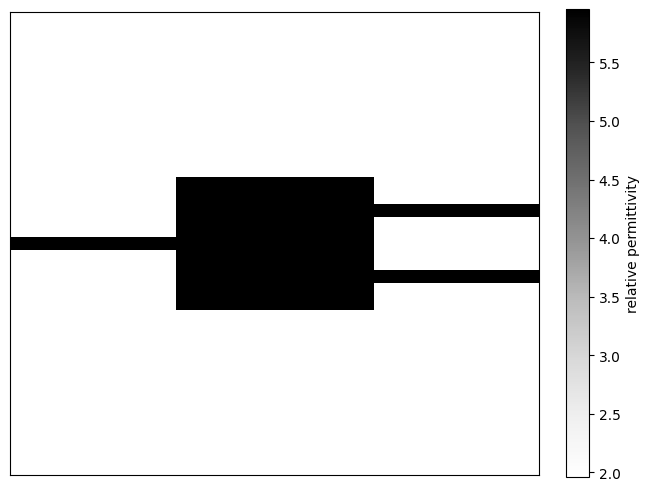

In [6]:
# define permittivity of three port system
eps_r, design_region = N2N_port(1, 2, L, H, w, d, d, l, spc, dl, NPML, eps_m, eps_background)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

# make a new simulation object
simulation = Simulation(omega, eps_r, dl, NPML, pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))

# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

In [7]:
# set the input waveguide modal source
simulation.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[NPML[0]+int(l/2/dl), ny], width=int(H/2/dl), scale=source_amp)
simulation.setup_modes(eps_background)

# make a new simulation to get the modal profile of the top output port
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], width=int(H/2/dl))
top.setup_modes(eps_background)
J_top = np.abs(top.src)

# make a new simulation to get the modal profile of the bottom output port
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], width=int(H/2/dl))
bot.setup_modes(eps_background)
J_bot = np.abs(bot.src)

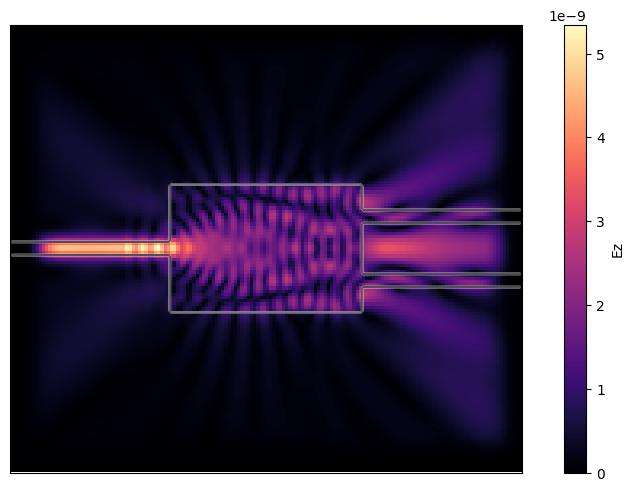

In [8]:
# set source and solve for electromagnetic fields
(Hx, Hy, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);